In [2]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

C:\Users\Takeshi Watanabe\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Takeshi Watanabe\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Takeshi Watanabe\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Takeshi Watanabe\anaconda3\envs\py

In [3]:
# Excelファイルから過去レートを読み込む
df = pd.read_excel(r"C:\Users\Takeshi Watanabe\Documents\jupyter-notebook\2015_wdata.xlsx")

In [4]:
# データの最初の5行を表示
df.head()

,発電量,peak AM,peak PM,日射量,気温,雲量
0,0.0,0,0,0.0,1.6,2
1,0.0,0,0,0.0,2.3,2
2,0.0,0,0,0.0,2.6,2
3,0.0,0,0,0.0,1.5,2
4,0.0,0,0,0.0,0.9,2


In [5]:
# 終値を1日分移動させる
df_shift = df.copy()
df_shift.発電量 = df_shift.発電量.shift(-1)

In [6]:
# 改めてデータを確認
df_shift.tail()

,発電量,peak AM,peak PM,日射量,気温,雲量
1770,0.0,0,0,0.0,12.9,9
1771,0.0,0,0,0.0,11.5,9
1772,0.0,0,0,0.0,11.2,2
1773,0.0,0,0,0.0,10.5,2
1774,NaN,0,0,0.0,9.4,2


In [7]:
# 最後の行を除外
df_shift = df_shift[:-1]
 
# 念のためデータをdf_2として新しいデータフレームへコピ−
df_2 = df_shift.copy()
 
 
# データセットのサイズを確認
print(df_2.shape[0])
print(df_2.shape[1])

1774
6


In [8]:
# データセットの行数と列数を格納
n = df_2.shape[0]
p = df_2.shape[1]
 
# 訓練データとテストデータへ切り分け
train_start = 0
train_end = int(np.floor(0.9*n))
test_start = train_end + 1
test_end = n
data_train = df_2.loc[np.arange(train_start, train_end), :]
data_test = df_2.loc[np.arange(test_start, test_end), :]

In [9]:
# データの正規化
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train_norm = scaler.transform(data_train)
data_test_norm = scaler.transform(data_test)

In [10]:
# 特徴量とターゲットへ切り分け
X_train = data_train_norm[:, 1:]
y_train = data_train_norm[:, 0]
X_test = data_test_norm[:, 1:]
y_test = data_test_norm[:, 0]

In [11]:
# 正規化から通常の値へ戻す
y_test = y_test.reshape(177, 1)
test_inv = np.concatenate((y_test, X_test), axis=1)
test_inv = scaler.inverse_transform(test_inv)

In [12]:
# 正規化の前のテストデータ
print(data_test.values[0])
 
# 正規化後のテストデータ
print(y_test[0], X_test[0])
 
# 正規化から戻したデータ
print(test_inv[0])

[ 2.8148  0.      0.      0.333  14.8     6.    ]
[-0.69830654] [-1.         -1.         -0.35402522  0.51818182  0.2       ]
[ 2.8148  0.      0.      0.333  14.8     6.    ]


In [13]:
# 訓練データの特徴量の数を取得
n_stocks = X_train.shape[1]
 
# ニューロンの数を設定
n_neurons_1 = 256
n_neurons_2 = 128
 
# セッションの開始
net = tf.InteractiveSession()
 
# プレースホルダーの作成
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])
 
# 初期化
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [14]:
# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

In [15]:
# 出力の重み
W_out = tf.Variable(weight_initializer([n_neurons_2, 1]))
bias_out = tf.Variable(bias_initializer([1]))

In [16]:
# 隠れ層の設定（ReLU＝活性化関数）
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
 
# 出力層の設定
out = tf.transpose(tf.add(tf.matmul(hidden_2, W_out), bias_out))

In [17]:
# コスト関数
mse = tf.reduce_mean(tf.squared_difference(out, Y))
 
# 最適化関数
opt = tf.train.AdamOptimizer().minimize(mse)
 
# 初期化
net.run(tf.global_variables_initializer())

In [18]:
# ニューラルネットワークの設定
batch_size = 128
mse_train = []
mse_test = []
 
# 訓練開始！100回の反復処理
epochs = 100
for e in range(epochs):
    net.run(opt, feed_dict={X: X_train, Y: y_train})

In [19]:
# テストデータで予測
pred_test = net.run(out, feed_dict={X: X_test})

In [20]:
# 予測値をテストデータに戻そう（値も正規化からインバース）
pred_test = np.concatenate((pred_test.T, X_test), axis=1)
pred_inv = scaler.inverse_transform(pred_test)

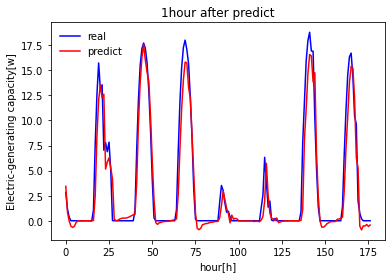

In [27]:
# 予測と実際のテストの終値のチャートをプロットしてみよう
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot()
line1, = ax1.plot(test_inv[:,0],'-b',label='real')
line2, = ax1.plot(pred_inv[:,0],'-r',label='predict')
leg = ax1.legend(frameon=False)
plt.xlabel('hour[h]')
plt.ylabel('Electric-generating capacity[w]')
plt.title('1hour after predict')
plt.show()